# Multi-Layer Perceptron(MLP) for Multi-Classification Problems

### University of the Sydney COMP5329 S1 Assignment1

### From Xin Shu   SID: 500623789



## 1. Required Packages and Data Import

### 1.1 Import the packages

In [ ]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation

### 1.2 Read data

Get data from GitHub: need to clone my reposity.

Note: If you have already cloned, you don't need to run this part of the code.

In [ ]:
!git clone https://github.com/ShuXin79/MLP-classification

Cloning into 'MLP-classification'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 16 (delta 0), reused 9 (delta 0), pack-reused 7
Unpacking objects: 100% (16/16), 56.52 MiB | 9.68 MiB/s, done.


In [ ]:
DATASET_PATH = 'MLP-classification/dataset'     #Relative path

X_train = np.load(DATASET_PATH + '/train_data.npy')
X_test = np.load(DATASET_PATH + '/test_data.npy')

y_train = np.load(DATASET_PATH + '/train_label.npy')
y_test = np.load(DATASET_PATH + '/test_label.npy')

print("The size of training set data, test set data, training set label, test set label:")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

The size of training set data, test set data, training set label, test set label:
(50000, 128)
(50000, 1)
(10000, 128)
(10000, 1)


### 1.3 Label to one-hot

In [ ]:
def OneHot(label_array):

  unique_label = list(set(label_array))
  label_dic = {j: i for i, j in enumerate(unique_label)}    # Build dictionary for unique labels
  one_hot_label = [[0] * len(unique_label) for _ in range(len(label_array))]  #Initialize all elements to 0
  for i, j in enumerate(label_array):            # Update one-hot labels
    one_hot_label[i][label_dic[j]] = 1
  return (one_hot_label)

y_train = OneHot(y_train.reshape(50000,))
y_train = np.array(y_train)
y_test = OneHot(y_test.reshape(10000,))
y_test = np.array(y_test)

print(y_test)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


## 2.Function Definition

### 2.1 Activation function

ReLU(x) = max(x,0)

In [ ]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

### 2.2 Softmax and cross-entropy function

softmax(x_i) = e^x_i / sum(e^x_j) for all j

Cross entropy loss = -Σ(y_true * log(y_pred) + (1-y_true) * log(1-y_pred))

In [ ]:
# Since softmax is used in the output layer, we don't need to define derivative function
def softmax(x):
  exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
  return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
  n_sample = y_true.shape[0]
  return -np.sum(y_true * np.log(y_pred)) / n_sample

### 2.3 Dropout function

In [ ]:
def dropout_forward(all_neu, dropout_rate):
  dropout_neu = (np.random.rand(*all_neu.shape) >= dropout_rate) / (1 - dropout_rate)  # Drop some neurons according to probability， drop rate
  keep_neu = all_neu * dropout_neu
  return keep_neu, dropout_neu

def dropout_backward(bac_keep, dropout_neu):
  bac_neu = bac_keep * dropout_neu
  return bac_neu

### 2.4 Mini-batch splitting function

In [ ]:
def mini_batch_split(X, y, batch_size):
  batch = np.arange(X.shape[0])
  np.random.shuffle(batch)     # Mess up the order
  mini_batches = [(X[batch][i:i + batch_size], y[batch][i:i + batch_size]) for i in range(0, X.shape[0], batch_size)] #Spilt into several batches that have the given batch size
  return mini_batches

### 2.5 Batch Normalization

*This part is not applied in the model, because there is a problem with the update found during testing.

In [ ]:
# Parameters
# gamma and beta: they are actually weight and bias, they will be updated in batch normalization
# eps: a small value prevents numerical calculation errors
# mean and var represent mean and variance
def batch_norm_forward(X, gamma, beta, eps=1e-8):
    mean = np.mean(X)
    var = np.var(X)
    X_norm = (X - mean) / np.sqrt(var + eps)  # Normalization
    norm_output = gamma * X_norm + beta
    cache = (X, X_norm, mean, var, gamma, beta, eps)
    return norm_output, cache

def batch_norm_backward(dnorm_output, cache):
    X, X_norm, mean, var, gamma, beta, eps = cache
    dX_norm = dnorm_output * gamma
    dvar = np.sum(dX_norm * (X - mean) * (-0.5) * (var + eps)**(-1.5))
    dmean = np.sum(-dX_norm / np.sqrt(var + eps)) - dvar * np.mean(2 * (X - mean))
    dX = dX_norm / np.sqrt(var + eps) + dvar * 2 * (X - mean) / X.shape[0] + dmean / X.shape[0]
    dgamma = np.sum(dnorm_output * X_norm)      # Update gamma and beta
    dbeta = np.sum(dnorm_output)
    return dX, dgamma, dbeta

## 3. MLP Implementation

### 3.1 **Three** HiddenLayers definition and initialization

In [ ]:
# Define the neural structure
input_size = X_train.shape[1]   # 128
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
output_size = y_train.shape[1]   # 10


# Initialize the weights and biases
# Wi, bi: The weights matrix and bias

W1 = np.random.randn(input_size, hidden_size1) / np.sqrt(input_size)
b1 = np.zeros((1, hidden_size1))
W2 = np.random.randn(hidden_size1, hidden_size2) / np.sqrt(hidden_size1)
b2 = np.zeros((1, hidden_size2))
W3 = np.random.randn(hidden_size2, hidden_size3) / np.sqrt(hidden_size2)
b3 = np.zeros((1, hidden_size3))
W4 = np.random.randn(hidden_size3, output_size) / np.sqrt(hidden_size3)
b4 = np.zeros((1, output_size))



### 3.2 Momentum-weights&biases initialization

In [ ]:
# Initialize velocity for momentum
Mom_W1 = np.zeros(W1.shape)
Mom_b1 = np.zeros(b1.shape)
Mom_W2 = np.zeros(W2.shape)
Mom_b2 = np.zeros(b2.shape)
Mom_W3 = np.zeros(W3.shape)
Mom_b3 = np.zeros(b3.shape)
Mom_W4 = np.zeros(W4.shape)
Mom_b4 = np.zeros(b4.shape)

### 3.3 Training: forward propagation and backward propagation

In [ ]:
import time

# Define the parameters, which can be changed easily for model improvement
epochs = 500
learning_rate = 0.001
momentum = 0.8
weight_decay = 0.00001
batch_size = 512
dropout_rate = 0.2

start_time = time.time()
total_loss = []

# Training loop
for epoch in range(epochs):
  mini_batch = mini_batch_split(X_train, y_train, batch_size)

  for X_batch, y_batch in mini_batch:

    # Forward propagation
    # Zi, Ai: The initial output value of the layer and the activated value

    Z1 = np.dot(X_batch, W1) + b1
    A1 = relu(Z1)
    #I only added the dropout method to the first hidden layer (I found underfitting easily occurred so I don't want to apply dropout across the board)
    A1, dropout_neu = dropout_forward(A1, dropout_rate) 
    Z2 = np.dot(A1, W2) + b2
    A2 = relu(Z2)
    Z3 = np.dot(A2, W3) + b3
    A3 = relu(Z3)
    Z4 = np.dot(A3, W4) + b4
    A4 = softmax(Z4)
    
    # Compute loss with weight decay
    loss = cross_entropy_loss(y_batch, A4) + weight_decay * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)) + np.sum(np.square(W4)))

    # Backward propagation
    # dZi, dWi, dbi: Output values from backward propagation and updated weights/biases. 'd' means partial derivative, used to computes the gradients and update weights

    dZ4 = A4 - y_batch
    dW4 = np.dot(A3.T, dZ4) / X_batch.shape[0]
    db4 = np.sum(dZ4, axis=0) / X_batch.shape[0]
    dA3 = np.dot(dZ4, W4.T)
    dZ3 = dA3 * relu_derivative(Z3)
    dW3 = np.dot(A2.T, dZ3) / X_batch.shape[0]
    db3 = np.sum(dZ3, axis=0) / X_batch.shape[0]
    dA2 = np.dot(dZ3, W3.T)
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = np.dot(A1.T, dZ2) / X_batch.shape[0]
    db2 = np.sum(dZ2, axis=0) / X_batch.shape[0]
    dA1 = np.dot(dZ2, W2.T)
    dA1 = dropout_backward(dA1, dropout_neu)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X_batch.T, dZ1) + weight_decay * W1
    db1 = np.sum(dZ1, axis=0) / X_batch.shape[0]

    # Update gradients with weight decay
    dW1 += weight_decay * W1
    dW2 += weight_decay * W2
    dW3 += weight_decay * W3
    dW4 += weight_decay * W4

    # Update weights and biases with momentum
    Mom_W4 = momentum * Mom_W4 + learning_rate * dW4
    W4 -= Mom_W4
    Mom_b4 = momentum * Mom_b4 + learning_rate * db4
    b4 -= Mom_b4

    Mom_W3 = momentum * Mom_W3 + learning_rate * dW3
    W3 -= Mom_W3
    Mom_b3 = momentum * Mom_b3 + learning_rate * db3
    b3 -= Mom_b3

    Mom_W2 = momentum * Mom_W2 + learning_rate * dW2
    W2 -= Mom_W2
    Mom_b2 = momentum * Mom_b2 + learning_rate * db2
    b2 -= Mom_b2

    Mom_W1 = momentum * Mom_W1 + learning_rate * dW1
    W1 -= Mom_W1
    Mom_b1 = momentum * Mom_b1 + learning_rate * db1
    b1 -= Mom_b1


  total_loss.append(loss)
  # Print loss every 10 epochs
  if epoch % 10 == 0:
    print(f"Epoch {epoch}, Loss: {loss:.4f}")

end_time = time.time()

Epoch 0, Loss: 1.7221
Epoch 10, Loss: 1.4073
Epoch 20, Loss: 1.4616
Epoch 30, Loss: 1.2865
Epoch 40, Loss: 1.3180
Epoch 50, Loss: 1.2032
Epoch 60, Loss: 1.3174
Epoch 70, Loss: 1.2002
Epoch 80, Loss: 1.2555
Epoch 90, Loss: 1.1299
Epoch 100, Loss: 1.1376
Epoch 110, Loss: 1.1260
Epoch 120, Loss: 1.1713
Epoch 130, Loss: 1.1988
Epoch 140, Loss: 1.1291
Epoch 150, Loss: 1.1814
Epoch 160, Loss: 1.0447
Epoch 170, Loss: 1.0594
Epoch 180, Loss: 1.1305
Epoch 190, Loss: 1.0938
Epoch 200, Loss: 1.0969
Epoch 210, Loss: 1.1536
Epoch 220, Loss: 1.0946
Epoch 230, Loss: 1.0796
Epoch 240, Loss: 1.0512
Epoch 250, Loss: 1.0354
Epoch 260, Loss: 1.1906
Epoch 270, Loss: 1.0466
Epoch 280, Loss: 1.1115
Epoch 290, Loss: 1.0367
Epoch 300, Loss: 1.1160
Epoch 310, Loss: 1.0187
Epoch 320, Loss: 1.1283
Epoch 330, Loss: 1.0883
Epoch 340, Loss: 1.0153
Epoch 350, Loss: 1.0202
Epoch 360, Loss: 0.9919
Epoch 370, Loss: 1.0433
Epoch 380, Loss: 1.0437
Epoch 390, Loss: 0.9843
Epoch 400, Loss: 1.0828
Epoch 410, Loss: 1.0240
Epo

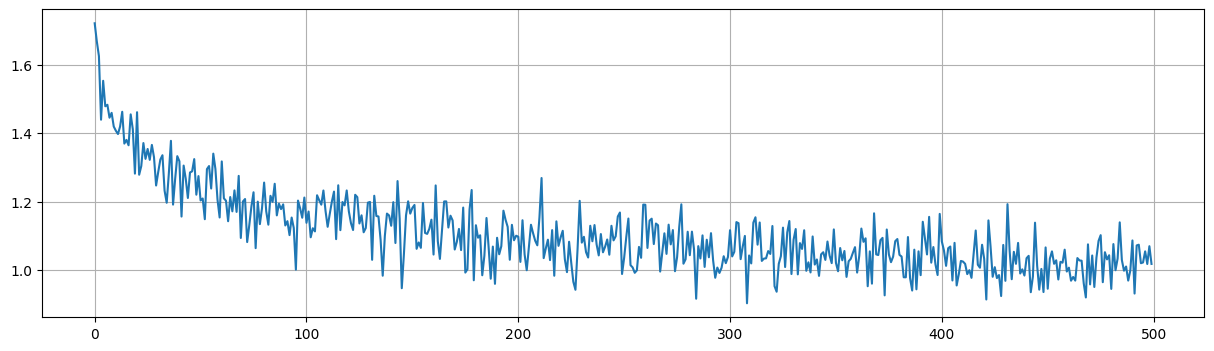

In [ ]:
# Plot loss in epochs
pl.figure(figsize=(15,4))
pl.plot(total_loss)
pl.grid()

## 4. Test and Evaluation

### 4.1 Test


In [ ]:
# The test is actually to perform the forward propagation process again
Z1_test = np.dot(X_test, W1) + b1
A1_test = relu(Z1_test)
Z2_test = np.dot(A1_test, W2) + b2
A2_test = relu(Z2_test)
Z3_test = np.dot(A2_test, W3) + b3
A3_test = relu(Z3_test)
Z4_test = np.dot(A3_test, W4) + b4
A4_test = softmax(Z4_test)


# Make prediction
y_pred = np.argmax(A4_test, axis=1)
y_true = np.argmax(y_test, axis=1)

print('Classification complete!')
print('Time cost:', round(end_time-start_time,2), 'seconds')
print('Predicted label:')
print(y_pred)
print('True label:')
print(y_true)



Classification complete!
Time cost: 2108.29 seconds
Predicted label:
[3 8 8 ... 5 5 7]
True label:
[3 8 8 ... 5 1 7]


### 4.2 Calculate accuracy

Accuracy = (TP + TN) / (TP+ FP + TN + FN)

In [ ]:
count = len(y_true)
correct = sum(t == p for t, p in zip(y_true, y_pred)) 
accuracy = correct / count

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 56.94%


### 4.3 Show the confusion matrix

An n*n matrix showing TP TN FP FN, where n represents the number of label types. The diagonal of the matrix represents the correct classification.

In [ ]:
num_classes = max(max(y_true), max(y_pred)) + 1
cm = [[0] * num_classes for _ in range(num_classes)]
for true, pred in zip(y_true, y_pred):
  cm[true][pred] += 1

print('Confusion Matrix:')
for row in cm:
    print(row)

Confusion Matrix:
[628, 43, 65, 17, 34, 15, 22, 17, 101, 58]
[25, 672, 10, 25, 16, 17, 15, 18, 49, 153]
[69, 16, 398, 74, 145, 95, 97, 63, 21, 22]
[20, 16, 69, 385, 80, 192, 109, 72, 21, 36]
[28, 10, 135, 58, 489, 56, 92, 97, 22, 13]
[16, 5, 65, 174, 73, 491, 73, 75, 9, 19]
[3, 16, 54, 77, 95, 53, 662, 17, 8, 15]
[19, 8, 32, 48, 88, 83, 24, 656, 12, 30]
[88, 70, 11, 27, 34, 20, 13, 8, 679, 50]
[26, 154, 13, 23, 17, 20, 26, 41, 46, 634]


Obviously the classification of the 3rd, 4th, 5th, and 6th labels is not good. Since the model fits well on the test set, I strongly suspect that this is not my problem LOL

## 5. Comparison and Improvement

###5.1 ONLY USED FOR COMPARISON: MLP classifier based on sklearn framework.

I used sklearn to build the most basic MLP classifier, hoping to compare 
it with my own MLP implemented above. Note: The classifiers in this part 
are **ONLY USED TO COMPARE** the MLP I implemented manually, please do not 
impose score penalties for this!

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

start_time1 = time.time()

X_train1 = np.load(DATASET_PATH + '/train_data.npy')
X_test1 = np.load(DATASET_PATH + '/test_data.npy')

y_train1 = np.load(DATASET_PATH + '/train_label.npy')
y_test1 = np.load(DATASET_PATH + '/test_label.npy')
y_train1 = y_train1.reshape(50000,)
y_test1 = y_test1.reshape(10000,)


mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42, max_iter=500)

mlp_classifier.fit(X_train1, y_train1)

y_pred1 = mlp_classifier.predict(X_test1)

accuracy1 = accuracy_score(y_test1, y_pred1)
print(f'Accuracy: {accuracy1 * 100:.2f}%')

end_time1 = time.time()
print('Time cost:', round(end_time1-start_time1,2), 'seconds')

Accuracy: 51.18%
Time cost: 257.49 seconds


The performance of model based on sklearn is not good either.

###5.2 Performance improvement attempt: use GELU activation function instead of ReLU

In [ ]:
from scipy.special import erf
import time

# Initialization, the same as privious code
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64
hidden_size3 = 32
output_size = y_train.shape[1]

W1 = np.random.randn(input_size, hidden_size1) / np.sqrt(input_size)
b1 = np.zeros((1, hidden_size1))
W2 = np.random.randn(hidden_size1, hidden_size2) / np.sqrt(hidden_size1)
b2 = np.zeros((1, hidden_size2))
W3 = np.random.randn(hidden_size2, hidden_size3) / np.sqrt(hidden_size2)
b3 = np.zeros((1, hidden_size3))
W4 = np.random.randn(hidden_size3, output_size) / np.sqrt(hidden_size3)
b4 = np.zeros((1, output_size))

Mom_W1 = np.zeros(W1.shape)
Mom_b1 = np.zeros(b1.shape)
Mom_W2 = np.zeros(W2.shape)
Mom_b2 = np.zeros(b2.shape)
Mom_W3 = np.zeros(W3.shape)
Mom_b3 = np.zeros(b3.shape)
Mom_W4 = np.zeros(W4.shape)
Mom_b4 = np.zeros(b4.shape)

# Define the GELU function
def gelu(x):
    return 0.5 * x * (1 + erf(x / np.sqrt(2)))

def gelu_derivative(x):
    c = np.sqrt(2 / np.pi)
    return 0.5 * (1 + erf(x / np.sqrt(2))) + c * x * np.exp(-x**2 / 2)

# The same code as before, but changed ReLU activition function to GELU 

epochs = 200  

learning_rate = 0.001
momentum = 0.8
weight_decay = 0.00001
batch_size = 512
dropout_rate = 0.2

start_time = time.time()
total_loss = []

for epoch in range(epochs):
  mini_batches = mini_batch_split(X_train, y_train, batch_size)

  for X_batch, y_batch in mini_batches:

    Z1 = np.dot(X_batch, W1) + b1
    A1 = gelu(Z1)

    A1, dropout_neu = dropout_forward(A1, dropout_rate) 
    Z2 = np.dot(A1, W2) + b2
    A2 = gelu(Z2)
    Z3 = np.dot(A2, W3) + b3
    A3 = gelu(Z3)
    Z4 = np.dot(A3, W4) + b4
    A4 = softmax(Z4)

    loss = cross_entropy_loss(y_batch, A4) + weight_decay * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)) + np.sum(np.square(W4)))

    dZ4 = A4 - y_batch
    dW4 = np.dot(A3.T, dZ4) / X_batch.shape[0]
    db4 = np.sum(dZ4, axis=0, keepdims=True) / X_batch.shape[0]
    dA3 = np.dot(dZ4, W4.T)
    dZ3 = dA3 * gelu_derivative(Z3)
    dW3 = np.dot(A2.T, dZ3) / X_batch.shape[0]
    db3 = np.sum(dZ3, axis=0, keepdims=True) / X_batch.shape[0]
    dA2 = np.dot(dZ3, W3.T)
    dZ2 = dA2 * gelu_derivative(Z2)
    dW2 = np.dot(A1.T, dZ2) / X_batch.shape[0]
    db2 = np.sum(dZ2, axis=0, keepdims=True) / X_batch.shape[0]
    dA1 = np.dot(dZ2, W2.T)
    dA1 = dropout_backward(dA1, dropout_neu)
    dZ1 = dA1 * gelu_derivative(Z1)
    dW1 = np.dot(X_batch.T, dZ1) + weight_decay * W1
    db1 = np.sum(dZ1, axis=0, keepdims=True) / X_batch.shape[0]

    # Update gradients with weight decay
    dW1 += weight_decay * W1
    dW2 += weight_decay * W2
    dW3 += weight_decay * W3
    dW4 += weight_decay * W4

    # Update weights and biases with momentum
    Mom_W4 = momentum * Mom_W4 + learning_rate * dW4
    W4 -= Mom_W4
    Mom_b4 = momentum * Mom_b4 + learning_rate * db4
    b4 -= Mom_b4

    Mom_W3 = momentum * Mom_W3 + learning_rate * dW3
    W3 -= Mom_W3
    Mom_b3 = momentum * Mom_b3 + learning_rate * db3
    b3 -= Mom_b3

    Mom_W2 = momentum * Mom_W2 + learning_rate * dW2
    W2 -= Mom_W2
    Mom_b2 = momentum * Mom_b2 + learning_rate * db2
    b2 -= Mom_b2

    Mom_W1 = momentum * Mom_W1 + learning_rate * dW1
    W1 -= Mom_W1
    Mom_b1 = momentum * Mom_b1 + learning_rate * db1
    b1 -= Mom_b1


  total_loss.append(loss)
  # Print loss every 10 epochs
  if epoch % 10 == 0:
    print(f"Epoch {epoch}, Loss: {loss:.4f}")

end_time = time.time()


Epoch 0, Loss: 1.8121
Epoch 10, Loss: 1.5762
Epoch 20, Loss: 1.4078
Epoch 30, Loss: 1.4308
Epoch 40, Loss: 1.3716
Epoch 50, Loss: 1.3485
Epoch 60, Loss: 1.3847
Epoch 70, Loss: 1.3045
Epoch 80, Loss: 1.3358
Epoch 90, Loss: 1.2765
Epoch 100, Loss: 1.2521
Epoch 110, Loss: 1.3303
Epoch 120, Loss: 1.2949
Epoch 130, Loss: 1.2255
Epoch 140, Loss: 1.3359
Epoch 150, Loss: 1.2067
Epoch 160, Loss: 1.3543
Epoch 170, Loss: 1.2101
Epoch 180, Loss: 1.2817
Epoch 190, Loss: 1.2531


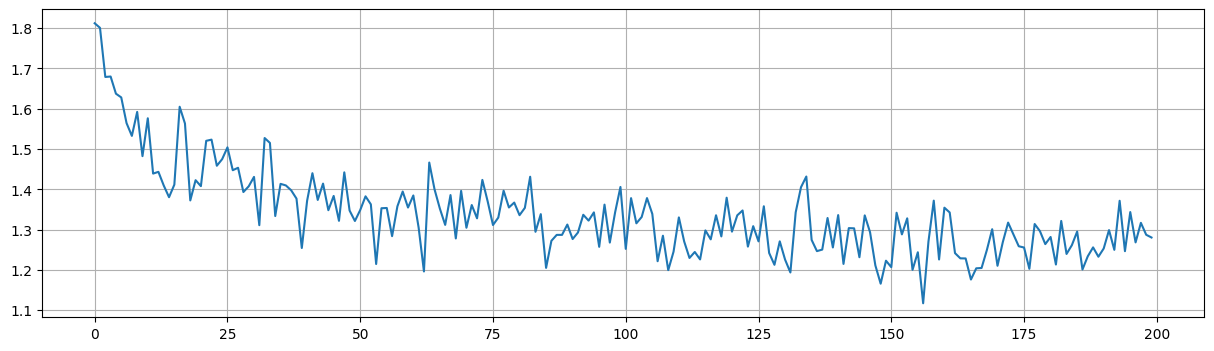

In [ ]:
pl.figure(figsize=(15,4))
pl.plot(total_loss)
pl.grid()

In [ ]:
Z1_test = np.dot(X_test, W1) + b1
A1_test = relu(Z1_test)
Z2_test = np.dot(A1_test, W2) + b2
A2_test = relu(Z2_test)
Z3_test = np.dot(A2_test, W3) + b3
A3_test = relu(Z3_test)
Z4_test = np.dot(A3_test, W4) + b4
A4_test = softmax(Z4_test)

y_pred = np.argmax(A4_test, axis=1)
y_true = np.argmax(y_test, axis=1)

print('Classification complete!')
print('Time cost:', round(end_time-start_time,2), 'seconds')
print('Predicted label:')
print(y_pred)
print('True label:')
print(y_true)

count = len(y_true)
correct = sum(t == p for t, p in zip(y_true, y_pred)) 
accuracy = correct / count

print(f'Accuracy: {accuracy * 100:.2f}%')

num_classes = max(max(y_true), max(y_pred)) + 1
cm = [[0] * num_classes for _ in range(num_classes)]
for true, pred in zip(y_true, y_pred):
  cm[true][pred] += 1

print('Confusion Matrix:')
for row in cm:
    print(row)

Classification complete!
Time cost: 986.83 seconds
Predicted label:
[0 8 8 ... 5 5 7]
True label:
[3 8 8 ... 5 1 7]
Accuracy: 54.35%
Confusion Matrix:
[594, 47, 58, 23, 29, 14, 20, 8, 141, 66]
[32, 633, 18, 19, 9, 8, 13, 13, 67, 188]
[58, 23, 400, 88, 159, 76, 93, 51, 23, 29]
[27, 21, 91, 346, 64, 201, 117, 59, 23, 51]
[34, 20, 136, 74, 464, 52, 103, 80, 23, 14]
[16, 15, 83, 221, 68, 416, 59, 75, 18, 29]
[5, 21, 73, 83, 105, 41, 620, 13, 14, 25]
[22, 11, 43, 49, 85, 98, 22, 614, 10, 46]
[76, 66, 14, 22, 19, 18, 9, 7, 708, 61]
[39, 159, 13, 32, 9, 18, 22, 20, 48, 640]


## Summary

In this experiment, I only built a simple three-hidden layer MLP classifier at the beginning, and got an initial accuracy rate of about 40%. By adding various optimizations to the model, the accuracy rate was finally increased to 56.9%. 

At the beginning, I found that my model was severely underfitting, so I was reluctant to add Dropout and Weight decay. I changed the weight update method to Momentum SGD and found that the convergence speed is greatly improved, The change in becomes very small around 100 epochs. The choice of ReLU and Softmax also effectively avoids gradient disappearance and gradient explosion. 

There has always been a big problem in the model implementation: colab often crashes due to insufficient RAM, and I don't want to waste money to recharge members to increase the RAM limit :( This problem is alleviated to some extent by using mini batch. 

Finally, after training for 500 epochs, I found that the accuracy rate reached 98% when verifying on the training set, but the performance on the test set was even worse, and I realized that there was overfitting. So I added dropout (only on the first hidden layer) and used weight decay. In these methods of preventing overfitting, the parameters I set are small, because I think the main problem I face is how to make the model better trained with limited resources.

In section 3.3: Training, All the parameters I use have been optimised many times. This notebook only shows what I believe to be the optimal model and parameters. In best result, the accuracy is 56.94%.

In section 5 I compared my model to sklearn, found that the performance of my model is better excluding running time. 

Additionally, for attempt of further optimition, I changed the activition function from ReLU to GeLU (not include the softmax of the last layer). The results show that the process of gradient descent is smoother (it can be seen from the loss), but the running time is longer, which I think is difficult to accept, because my MLP originally ran for a long time (I think this is a shortcoming of the model I implemented). In order to balance the time cost brought by GeLU, I reduced the number of neurons. The results show that under the same parameters (hidden layers 128, 64, 32, epochs = 200), the GeLU activation function brings a better accuracy rate of 54.35 (the ReLU model under the same conditions is only about 52%). 